# Importing the libraries

In [96]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, fbeta_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import neurolab as nl
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Loading the dataset

In [97]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/haberman/haberman.data"

# defining column names
column_names = ['age', 'year_of_operation', 'positive_axillary_nodes', 'survival_status']

# loading dataset
haberman_data = pd.read_csv(url, header=None, names=column_names)

# Visualising the data

In [3]:
print(haberman_data.shape)

# seeing the first 5 entries in the dataset
haberman_data.head()

(306, 4)


,age,year_of_operation,positive_axillary_nodes,survival_status
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


In [4]:
haberman_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   age                      306 non-null    int64
 1   year_of_operation        306 non-null    int64
 2   positive_axillary_nodes  306 non-null    int64
 3   survival_status          306 non-null    int64
dtypes: int64(4)
memory usage: 9.7 KB


In [5]:
haberman_data.describe()

,age,year_of_operation,positive_axillary_nodes,survival_status
count,306.000000,306.000000,306.000000,306.000000
mean,52.457516,62.852941,4.026144,1.264706
std,10.803452,3.249405,7.189654,0.441899
min,30.000000,58.000000,0.000000,1.000000
25%,44.000000,60.000000,0.000000,1.000000
50%,52.000000,63.000000,1.000000,1.000000
75%,60.750000,65.750000,4.000000,2.000000
max,83.000000,69.000000,52.000000,2.000000


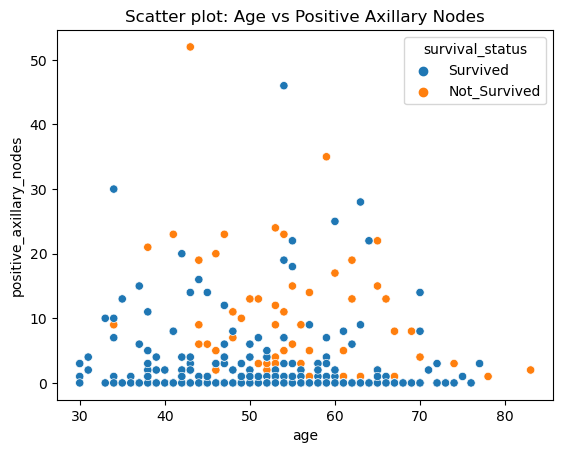

In [98]:
haberman_data['survival_status'] = haberman_data['survival_status'].map({1: 'Survived', 2: 'Not_Survived'})

sns.scatterplot(x='age', y='positive_axillary_nodes', hue='survival_status', data=haberman_data)
plt.title('Scatter plot: Age vs Positive Axillary Nodes')

plt.show()

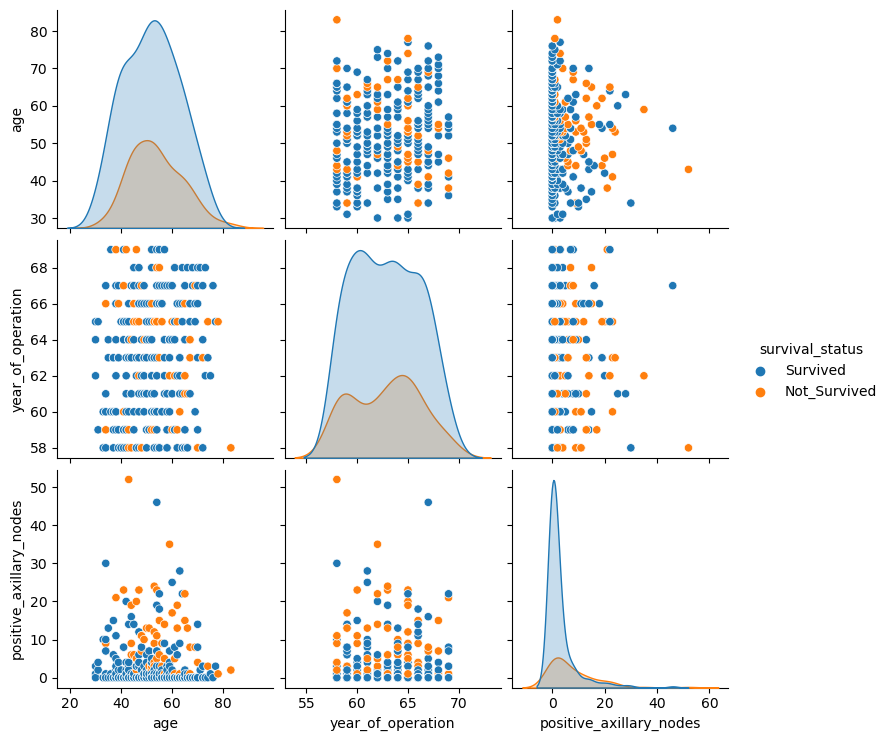

In [7]:
sns.pairplot(haberman_data, hue="survival_status")

# Visualising the outliers

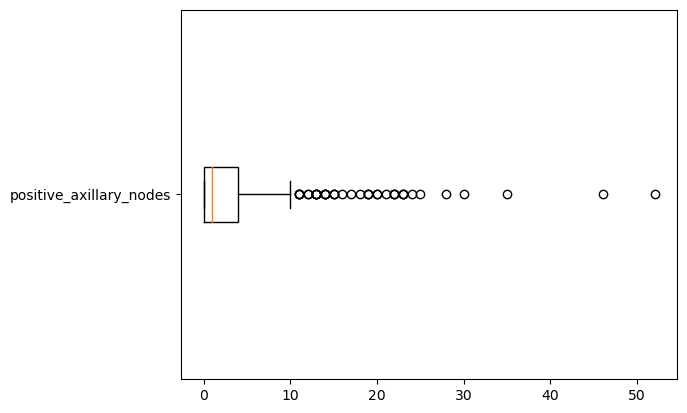

In [8]:
# creating a figure and axis
fig, ax = plt.subplots()

# creating a boxplot for 'positive_axillary_nodes'
ax.boxplot(haberman_data['positive_axillary_nodes'], vert=False)

# setting the y-axis label to 'positive_axillary_nodes'
ax.set_yticklabels(['positive_axillary_nodes'])

# displaying the plot
plt.show()

# Checking and removing outliers and missing values

In [9]:
# Calculating IQR for outlier detection
Q1 = haberman_data.quantile(0.25)
Q3 = haberman_data.quantile(0.75)
IQR = Q3 - Q1

# Defining a condition for outliers
outlier_condition = ((haberman_data < (Q1 - 1.5 * IQR)) | (haberman_data > (Q3 + 1.5 * IQR)))

# Counting the number of outliers in each column
outliers = np.where(outlier_condition)
outliers_count = len(set(outliers[0])) # using set to remove duplicate indices

print(f"Number of outlier entries: {outliers_count}")

# Removing the outliers
filtered_data = haberman_data[~outlier_condition.any(axis=1)]

# Checking how many values were missing initially
missing_initial = haberman_data.isnull().sum().sum()
print(f"Initial number of missing values: {missing_initial}")

# Checking for missing values after removing outliers
missing_after_removal = filtered_data.isnull().sum().sum()
print(f"Number of missing values after outlier removal: {missing_after_removal}")

# If there are any missing values after removing outliers, fill them with the mean
if missing_after_removal > 0:
    filtered_data.fillna(filtered_data.mean(), inplace=True)

# Checking how many missing values are remaining
missing_after_filling = filtered_data.isnull().sum().sum()
print(f"Number of missing values after filling: {missing_after_filling}")

# Printing the changes in the dataset
print(f"Original dataset shape: {haberman_data.shape}")
print(f"New dataset shape: {filtered_data.shape}")

Number of outlier entries: 40
Initial number of missing values: 0
Number of missing values after outlier removal: 0
Number of missing values after filling: 0
Original dataset shape: (306, 4)
New dataset shape: (266, 4)


/var/folders/rq/99tb0hsn31v90wm3p0pp2d100000gn/T/ipykernel_48604/3401880571.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = haberman_data.quantile(0.25)
/var/folders/rq/99tb0hsn31v90wm3p0pp2d100000gn/T/ipykernel_48604/3401880571.py:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = haberman_data.quantile(0.75)
/var/folders/rq/99tb0hsn31v90wm3p0pp2d100000gn/T/ipykernel_48604/3401880571.py:7: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outlier_condition = (

# Preprocessing the data

In [10]:
# Defining the feature columns and target column
features = haberman_data.drop(columns='survival_status')
target = haberman_data['survival_status']

# ensure all data are floating point
features = features.astype('float32')

# label encode strings to 0/1
target = LabelEncoder().fit_transform(target)

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# set number of input features
n_features = X_train.shape[1]

# Creating a MinMaxScaler
scaler = MinMaxScaler()

# Fitting the scaler to the training data and transforming the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transforming the test data
X_test_scaled = scaler.transform(X_test)

# Creating the model

In [11]:
def create_model():
    model = Sequential()
    model.add(Dense(10, activation='relu', input_shape=(n_features,)))
    model.add(Dense(1, activation='sigmoid'))
    
    # Set learning rate
    opt = Adam(learning_rate=0.3)
    
    model.compile(optimizer=opt, 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [15]:
model = create_model()

early_stopping = EarlyStopping(monitor='loss', 
                               min_delta=1e-5,  # Minimum change in the monitored quantity to qualify as an improvement
                               mode='min',  # Training will stop when the quantity monitored has stopped decreasing
                               patience=10,  # Number of epochs with no improvement after which training will be stopped
                               baseline=1e-5)  # Stop training when the monitored metric reaches this value

# Define the custom callback
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Train Loss: {logs["loss"]}, Train Accuracy: {logs["accuracy"]}, Validation Loss: {logs["val_loss"]}, Validation Accuracy: {logs["val_accuracy"]}')
        if(logs.get('loss') <= 1e-5):
            print("\nPerformance goal has been reached!")
            self.model.stop_training = True

history = model.fit(X_train, 
                    y_train, 
                    epochs=3000, 
                    batch_size=16, 
                    verbose=0, 
                    validation_data=(X_test,y_test),
                    callbacks=[CustomCallback(), early_stopping])

Epoch 0, Train Loss: 7.0225510597229, Train Accuracy: 0.6308411359786987, Validation Loss: 0.6319119930267334, Validation Accuracy: 0.717391312122345


# Testing the model with unseen data

In [16]:
model.evaluate(X_test, y_test)

predictions = (model.predict(X_test) > 0.5).astype("int32")

# classification_report
print(classification_report(y_test, predictions))

# confusion matrix
pd.DataFrame(confusion_matrix(y_test, predictions))

3/3 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.72      1.00      0.84        66

    accuracy                           0.72        92
   macro avg       0.36      0.50      0.42        92
weighted avg       0.51      0.72      0.60        92



/Users/tudorciutacu/opt/anaconda3/envs/NN/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tudorciutacu/opt/anaconda3/envs/NN/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tudorciutacu/opt/anaconda3/envs/NN/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

,0,1
0,0,26
1,0,66


3/3 [==============================] - 0s 1ms/step
Test accuracy: 71.73913043478261%


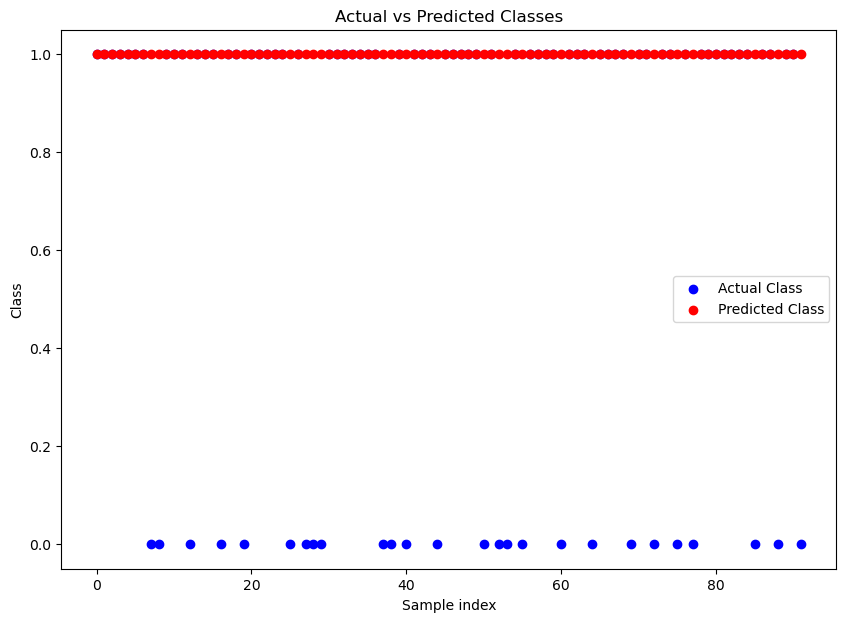

In [18]:
# Predict on the test set
y_pred_proba = model.predict(X_test_scaled)
y_pred = np.round(y_pred_proba).astype(int).flatten()

# Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f'Test accuracy: {accuracy * 100}%')

# Plotting the classified patterns
plt.figure(figsize=(10,7))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual Class')
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted Class')
plt.title('Actual vs Predicted Classes')
plt.xlabel('Sample index')
plt.ylabel('Class')
plt.legend()
plt.show()

# Tweaking the model

In [32]:
# Model creation function (added neurons and learning_rate as a parameter)
def create_model(neurons=10, learning_rate=0.01):
    model = Sequential()
    model.add(Dense(10, activation='relu', input_shape=(n_features,)))
    model.add(Dense(1, activation='sigmoid'))

    # Set learning rate
    opt = Adam(learning_rate=learning_rate)

    model.compile(optimizer=opt, 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Wrap the model with KerasClassifier
model = KerasClassifier(build_fn=create_model, verbose=0)

# Define the grid search parameters
param_grid = {
    'batch_size': [8, 16, 32, 64],
    'epochs': [100, 150, 200, 250],
    'neurons': [5, 10, 15, 20],
    'learning_rate': [0.001, 0.01, 0.1, 0.3],
}

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

# Convert the cv_results_ dictionary to a DataFrame
cv_results_df = pd.DataFrame(grid_result.cv_results_)

# Display relevant columns only
cv_results_df[['param_neurons', 'param_batch_size', 'param_epochs', 'param_learning_rate', 'mean_test_score', 'rank_test_score']].sort_values('rank_test_score').head(10)

/var/folders/rq/99tb0hsn31v90wm3p0pp2d100000gn/T/ipykernel_48604/2008059472.py:16: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


,param_neurons,param_batch_size,param_epochs,param_learning_rate,mean_test_score,rank_test_score
168,5,32,200,0.1,0.780060,1
179,20,32,250,0.001,0.775235,2
210,15,64,150,0.001,0.770931,3
113,10,16,250,0.001,0.770866,4
7,20,8,100,0.01,0.770670,5
...,...,...,...,...,...,...
195,20,64,100,0.001,0.705203,252
224,5,64,200,0.001,0.696401,253
194,15,64,100,0.001,0.691771,254
192,5,64,100,0.001,0.687337,255


In [77]:
# Backup the original cv_results_df before concatenation
cv_results_backup = cv_results_df.copy()

# Defining the base model
def base_model():
    model = Sequential()
    model.add(Dense(10, activation='relu', input_shape=(n_features,)))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(learning_rate=0.3)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the model with KerasClassifier
base_model = KerasClassifier(build_fn=base_model, epochs=3000, batch_size=16, verbose=0)

# Fit and evaluate the model
base_model.fit(X_train, y_train)
base_model_score = base_model.score(X_test, y_test)

/var/folders/rq/99tb0hsn31v90wm3p0pp2d100000gn/T/ipykernel_48604/2991045902.py:14: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  base_model = KerasClassifier(build_fn=base_model, epochs=3000, batch_size=16, verbose=0)


In [80]:
# Defining a new DataFrame with the base model's parameters and score
base_model_df = pd.DataFrame({
    'param_neurons': [10],
    'param_batch_size': [16],
    'param_epochs': [3000],
    'param_learning_rate': [0.3],
    'mean_test_score': [base_model_score],
    'rank_test_score': [0]  # Indicating that this was the base model
})

# Restore cv_results_df from backup before concatenation
cv_results_df = cv_results_backup.copy()

# Concatenating the base_model_df with the results from GridSearchCV
cv_results_df = pd.concat([base_model_df, cv_results_df], ignore_index=True)

cv_results_df[['param_neurons', 'param_batch_size', 'param_epochs', 'param_learning_rate', 'mean_test_score', 'rank_test_score']].sort_values('rank_test_score').head(10)

,param_neurons,param_batch_size,param_epochs,param_learning_rate,mean_test_score,rank_test_score
0,10,16,3000,0.3,0.717391,0
169,5,32,200,0.1,0.780060,1
180,20,32,250,0.001,0.775235,2
211,15,64,150,0.001,0.770931,3
114,10,16,250,0.001,0.770866,4
8,20,8,100,0.01,0.770670,5
82,10,16,150,0.001,0.766236,6
38,10,8,200,0.01,0.766171,7
245,5,64,250,0.01,0.766171,7
181,5,32,250,0.01,0.766171,7


# Experimenting with different data splits

In [84]:
# Define your best model
def best_model():
    model = Sequential()
    model.add(Dense(5, activation='relu', input_shape=(n_features,)))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(learning_rate=0.1)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the model with KerasClassifier
best_model = KerasClassifier(build_fn=best_model, epochs=200, batch_size=32, verbose=0)

# Define split ratios
split_ratios = [0.5, 0.6, 0.8, 0.9]

# Initialize results list
results = []

# For each split ratio, train and evaluate the model
for split_ratio in split_ratios:
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=split_ratio, random_state=42)
    
    # Fit the model
    best_model.fit(X_train, y_train)
    
    # Calculate the accuracy on the test set
    accuracy = best_model.score(X_test, y_test)
    
    # Append the results to the results list
    results.append({
        'split_ratio': split_ratio,
        'test_accuracy': accuracy
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

/var/folders/rq/99tb0hsn31v90wm3p0pp2d100000gn/T/ipykernel_48604/3848811326.py:11: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  best_model = KerasClassifier(build_fn=best_model, epochs=200, batch_size=32, verbose=0)


   split_ratio  test_accuracy
0          0.5       0.764706
1          0.6       0.739130
2          0.8       0.734694
3          0.9       0.713768


# Kohonen network

In [87]:
# Only selecting the features as the target needs to be dropped
X_unsupervised = features

min_max_scaler = preprocessing.MinMaxScaler()
X_normalized = min_max_scaler.fit_transform(X_unsupervised)

/Users/tudorciutacu/opt/anaconda3/envs/NN/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tudorciutacu/opt/anaconda3/envs/NN/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tudorciutacu/opt/anaconda3/envs/NN/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tudorciutacu/opt/anaconda3/envs/NN/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` 

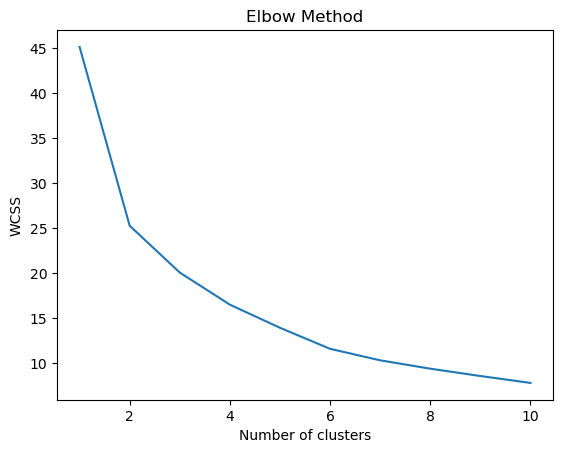

In [89]:
wcss = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X_normalized)
    wcss.append(kmeans.inertia_)

plt.plot(K_range, wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

/Users/tudorciutacu/opt/anaconda3/envs/NN/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tudorciutacu/opt/anaconda3/envs/NN/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tudorciutacu/opt/anaconda3/envs/NN/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tudorciutacu/opt/anaconda3/envs/NN/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` 

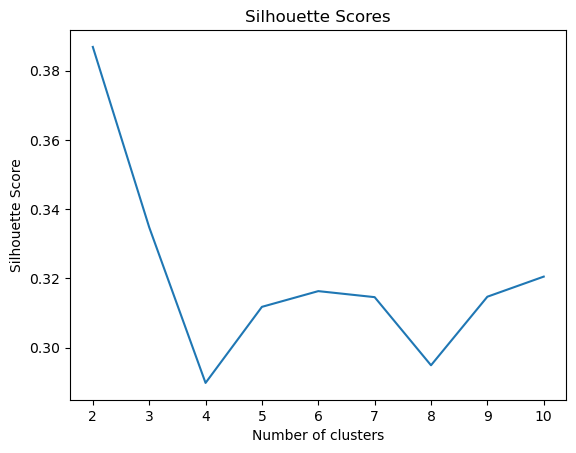

In [95]:
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X_normalized)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(X_normalized, labels))

plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

Epoch: 200; Error: 123.15755345378967;
Epoch: 400; Error: 123.15755345378967;
Epoch: 600; Error: 123.15755345378967;
Epoch: 800; Error: 123.15755345378967;
Epoch: 1000; Error: 123.15755345378967;
The maximum number of train epochs is reached
Epoch: 200; Error: 123.14899499233368;
Epoch: 400; Error: 123.14899499233368;
Epoch: 600; Error: 123.14899499233368;
Epoch: 800; Error: 123.14899499233368;
Epoch: 1000; Error: 123.14899499233368;
The maximum number of train epochs is reached


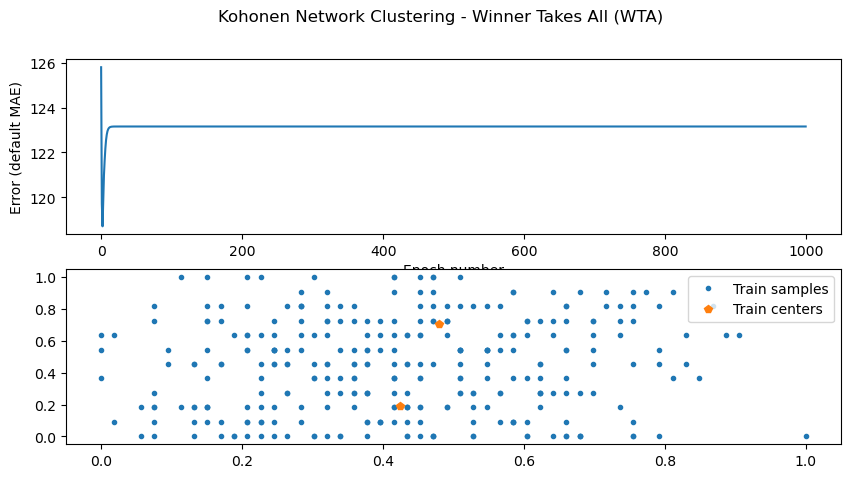

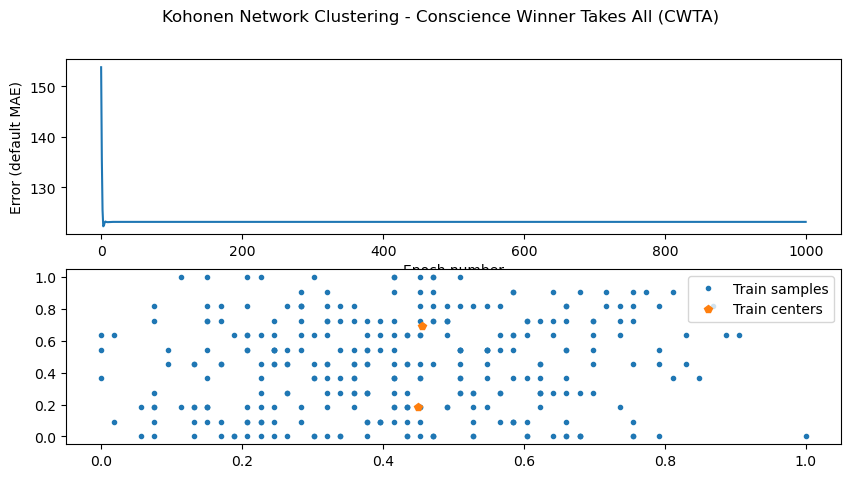

In [94]:
# Setting the optimal number of clusters as deducted from the above plots
n_clusters = 2

net_wta = nl.net.newc(nl.tool.minmax(X_normalized), n_clusters)
net_cwta = nl.net.newc(nl.tool.minmax(X_normalized), n_clusters)

net_wta.trainf = nl.train.train_wta
net_cwta.trainf = nl.train.train_cwta

error_wta = net_wta.train(X_normalized, epochs=1000, show=200)
error_cwta = net_cwta.train(X_normalized, epochs=1000, show=200)

# Results for Winner Takes All (WTA)
plt.figure(figsize=(10, 5))
plt.suptitle('Kohonen Network Clustering - Winner Takes All (WTA)')

plt.subplot(2, 1, 1)
plt.plot(error_wta)
plt.xlabel('Epoch number')
plt.ylabel('Error (default MAE)')

w_wta = net_wta.layers[0].np['w']
plt.subplot(2, 1, 2)
plt.plot(X_normalized[:, 0], X_normalized[:, 1], '.', w_wta[:, 0], w_wta[:, 1], 'p')
plt.legend(['Train samples', 'Train centers'])
plt.show()

# Results for Conscience Winner Takes All (CWTA)
plt.figure(figsize=(10, 5))
plt.suptitle('Kohonen Network Clustering - Conscience Winner Takes All (CWTA)')

plt.subplot(2, 1, 1)
plt.plot(error_cwta)
plt.xlabel('Epoch number')
plt.ylabel('Error (default MAE)')

w_cwta = net_cwta.layers[0].np['w']
plt.subplot(2, 1, 2)
plt.plot(X_normalized[:, 0], X_normalized[:, 1], '.', w_cwta[:, 0], w_cwta[:, 1], 'p')
plt.legend(['Train samples', 'Train centers'])
plt.show()